In [20]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import shdom
from scipy.ndimage import center_of_mass



In [21]:
def calccenterofmass(droplets):
    lwc = droplets.lwc.data
    mx = np.sum(np.sum(lwc,2),1)
    my = np.sum(np.sum(lwc,2),0)
    mz = np.sum(np.sum(lwc,0),0)
    com_x = sum(mx * droplets.grid.x)/sum(mx)
    com_y = sum(my * droplets.grid.y)/sum(my)
    com_z = sum(mz * droplets.grid.z)/sum(mz)
    return com_x, com_y, com_z

In [22]:

"""
Set settings
"""
#355, 380, 445, 470, 555, 660, 865, 935
vel_cloud = np.array([0.0,0.0,0.0]) # m/s
# A fly over from West to East (positive y-axis direction)
# camera_zenith_list = [70.5, 60, 45.6, 26.1, 0, 26.1, 45.6, 60, 70.5]
# camera_azimuth_list = [-90, -90, -90, -90, 0, 90, 90, 90, 90]
data_dir = '../AirMSPI/AirMSPI_ER2_GRP_ELLIPSOID_20130206_Pacific-32N123W'
output_dir = 'experiments/AirMSPI_simulation/dynamic_medium_monochromatic'
roi = [[1552, 2072, 780, 1288], [1644, 2108, 864, 1308], [1696, 2176, 916, 1376], [1740, 2196, 936, 1400], [1840, 2108, 1040, 1432], [1884, 2160, 1064, 1500], [1944, 2316, 1116, 1540], [1972, 2480, 1136, 1600], [2052, 2544, 1204, 1640]]
# roi = [[1500, 2108, 1040, 1432]]*9

airmspi_measurements = shdom.AirMSPIMeasurements()
airmspi_measurements.load_from_hdf(data_dir,region_of_interest=roi,valid_wavelength=[660])

wavelengths = airmspi_measurements.wavelength

In [23]:
if not isinstance(wavelengths,list):
        wavelengths = [wavelengths]
# solver
iter = 10

# Mie scattering for water droplets
mie_table_paths = [
    '../mie_tables/polydisperse/Water_{}nm.scat'.format(shdom.int_round(wavelength)) 
    for wavelength in wavelengths
]


# Generate a Microphysical medium
droplets = shdom.MicrophysicalScatterer()
droplets.load_from_csv('../synthetic_cloud_fields/jpl_les/rico52x57x26.txt', veff=0.1)

com_x, com_y, com_z = calccenterofmass(droplets=droplets)
com = np.array([com_x, com_y, com_z])


time_list = airmspi_measurements.time_list #sec


# Rayleigh scattering for air molecules up to 20 km
df = pd.read_csv('../ancillary_data/AFGL_summer_mid_lat.txt', comment='#', sep=' ')
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, 20, 20))
air = shdom.MultispectralScatterer()

In [24]:
for wavelength, table_path in zip(wavelengths, mie_table_paths):  
    # Molecular Rayleigh scattering
    rayleigh = shdom.Rayleigh(wavelength)
    rayleigh.set_profile(temperature_profile.resample(air_grid))
    air.add_scatterer(rayleigh.get_scatterer())
    
    # Droplet Mie scattering
    mie = shdom.MiePolydisperse()
    mie.read_table(table_path)
    droplets.add_mie(mie)
    


Reading mie table from file: ../mie_tables/polydisperse/Water_865nm.scat


In [25]:
nx = ny = nz = 40
nz=20
grid = shdom.Grid(x=np.linspace(droplets.grid.xmin,droplets.grid.xmax,52),y=np.linspace(droplets.grid.ymin-1,droplets.grid.ymax-1,57),z=np.linspace(droplets.grid.zmin,droplets.grid.zmax,26))
grid = shdom.Grid(x=np.linspace(0.5,1.5,52),y=np.linspace(46,47,57),z=np.linspace(0.5,1.5,26))
# droplets.resample(grid)

# x_min = airmspi_measurements.camera.projection.x.min()
# x_max = airmspi_measurements.camera.projection.x.max()
# dx = np.round((x_max-x_min)/nx,5)
# x = np.arange(x_min,x_max,dx)
# 
# y_min = airmspi_measurements.camera.projection.y.min()
# y_max = airmspi_measurements.camera.projection.y.max()
# dy = np.round((y_max-y_min)/ny,3)
# y = np.arange(y_min,y_max,dy)
# 
# grid = shdom.Grid(x=x,
#                   y=y,z=np.linspace(0, 20, nz))
# # droplets.resample(grid)

droplets.grid = grid


In [26]:
dynamic_scatterer = shdom.DynamicScatterer()
dynamic_scatterer.generate_dynamic_scatterer(scatterer=droplets, time_list=time_list, scatterer_velocity_list=vel_cloud)
dynamic_medium = shdom.DynamicMedium(dynamic_scatterer,air=air)

In [27]:
def get_rte_solver(measurements):
    scene_params_list = []
    numerical_params_list = []
    wavelengths = measurements.wavelength
    solar_spectrum = shdom.SolarSpectrum('../ancillary_data/SpectralSolar_MODWehrli_1985_WMO.npz')
    if not isinstance(wavelengths,list):
        wavelengths = [wavelengths]
    solar_fluxes = solar_spectrum.get_monochrome_solar_flux(wavelengths)
    solar_fluxes = solar_fluxes / max(solar_fluxes)
    
    for wavelength, sun_azimuth, sun_zenith, solar_flux in zip(wavelengths, measurements.sun_azimuth_list,
                                                   measurements.sun_zenith_list,solar_fluxes):
        scene_params = shdom.SceneParameters(
            wavelength=wavelength,
            surface=shdom.LambertianSurface(albedo=0.02),
            source=shdom.SolarSource(azimuth=sun_azimuth, zenith=sun_zenith, flux=solar_flux)
        )
        scene_params_list.append(scene_params)
        numerical_params = shdom.NumericalParameters(num_mu_bins=8, num_phi_bins=16, split_accuracy=0.1)
        numerical_params_list.append(numerical_params)

    dynamic_solver = shdom.DynamicRteSolver(scene_params=scene_params_list, numerical_params=numerical_params_list)
    return dynamic_solver

In [28]:
dynamic_solver = get_rte_solver(airmspi_measurements)
dynamic_solver.set_dynamic_medium(dynamic_medium)
dynamic_solver.solve(maxiter=iter)

In [29]:
projections = airmspi_measurements.camera.projection

In [30]:
dynamic_camera = shdom.DynamicCamera(shdom.RadianceSensor(), projections)
images = dynamic_camera.render(dynamic_solver,n_jobs=40)

In [31]:
measurements = shdom.AirMSPIMeasurementsv3(dynamic_camera, images=images, wavelength=wavelengths,time_list=time_list)
# measurements = shdom.DynamicMeasurements(dynamic_camera, images=images, wavelength=wavelengths,time_list=time_list)

In [32]:
measurements._sun_zenith_list = airmspi_measurements.sun_zenith_list
measurements._sun_azimuth_list = airmspi_measurements.sun_azimuth_list

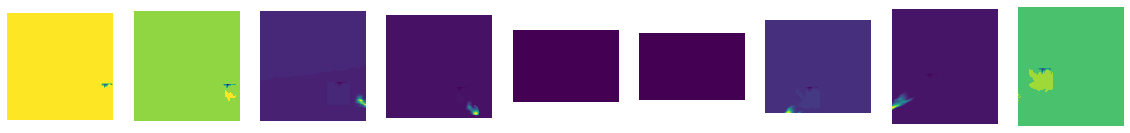

In [33]:
%matplotlib inline
first=True
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
for ax, image in zip(axarr, images):
    # if image.shape[2]==2:
    #     image = np.concatenate((np.zeros((200,200,1)),image/image.max()),2)
    ax.imshow(np.round(image,3))
    # ax.invert_xaxis() 
    # ax.invert_yaxis() 
    ax.axis('off')
    

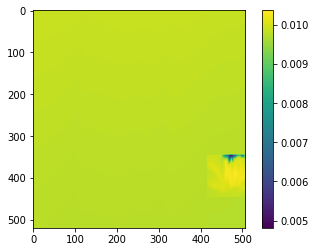

In [34]:
im = images[0]
plt.imshow(im)
# plt.gca().invert_yaxis() 
# plt.gca().invert_xaxis() 
plt.colorbar()


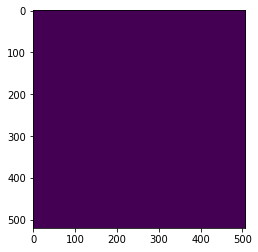

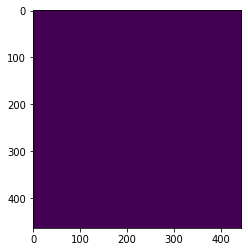

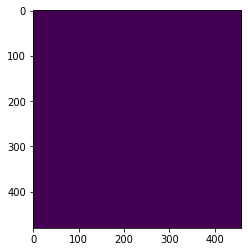

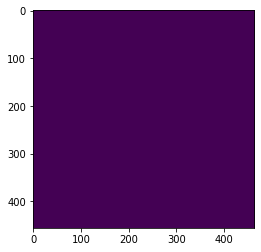

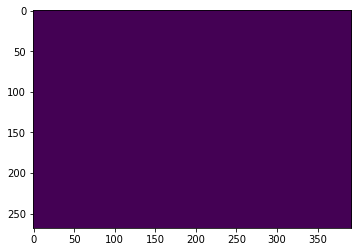

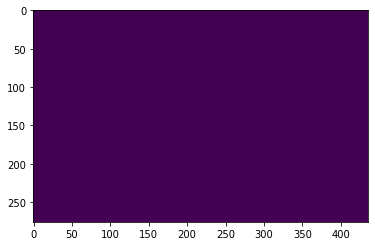

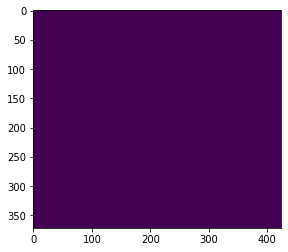

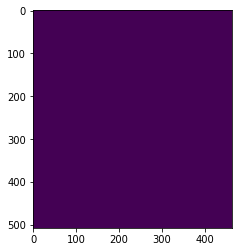

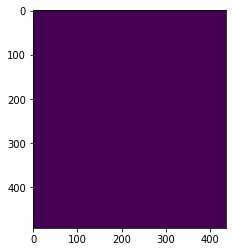

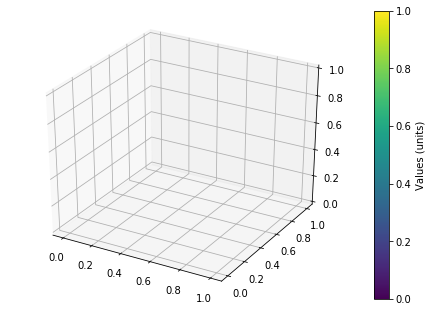

0


In [35]:
dynamic_carver = shdom.DynamicSpaceCarver(airmspi_measurements)
mask_list, dynamic_grid, cloud_velocity = dynamic_carver.carve(grid, agreement=0.7,
                    time_list = measurements.time_list, thresholds=0.00,
                    vx_max = 0, vy_max=0, gt_velocity = [0]*3)
show_mask=1
if show_mask:
    a = (mask_list[0].data).astype(int)
    shdom.cloud_plot(a)
    print(sum(sum(sum(a))))

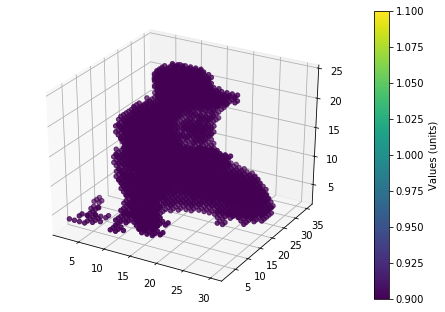

In [36]:
shdom.cloud_plot((droplets.lwc.data>0)+a)

In [37]:
measurements.save_airmspi_measurements(output_dir)

In [38]:
airmspi_measurements._images = images
output_dir = '../Develop_Dynamic_cloud/experiments/AirMSPI_simulation_img_sweap/dynamic_medium_polychromatic'

airmspi_measurements.save_airmspi_measurements(output_dir)